📊 Processing SRTT data with Isolation Forest:
  🔍 TEST:
    ✅ Cleaned 20 outliers using 236 features (4% contamination rate)
  🔍 BASELINE:
    ✅ Cleaned 20 outliers using 236 features (4% contamination rate)

🔄 Analyzing SRTT data...


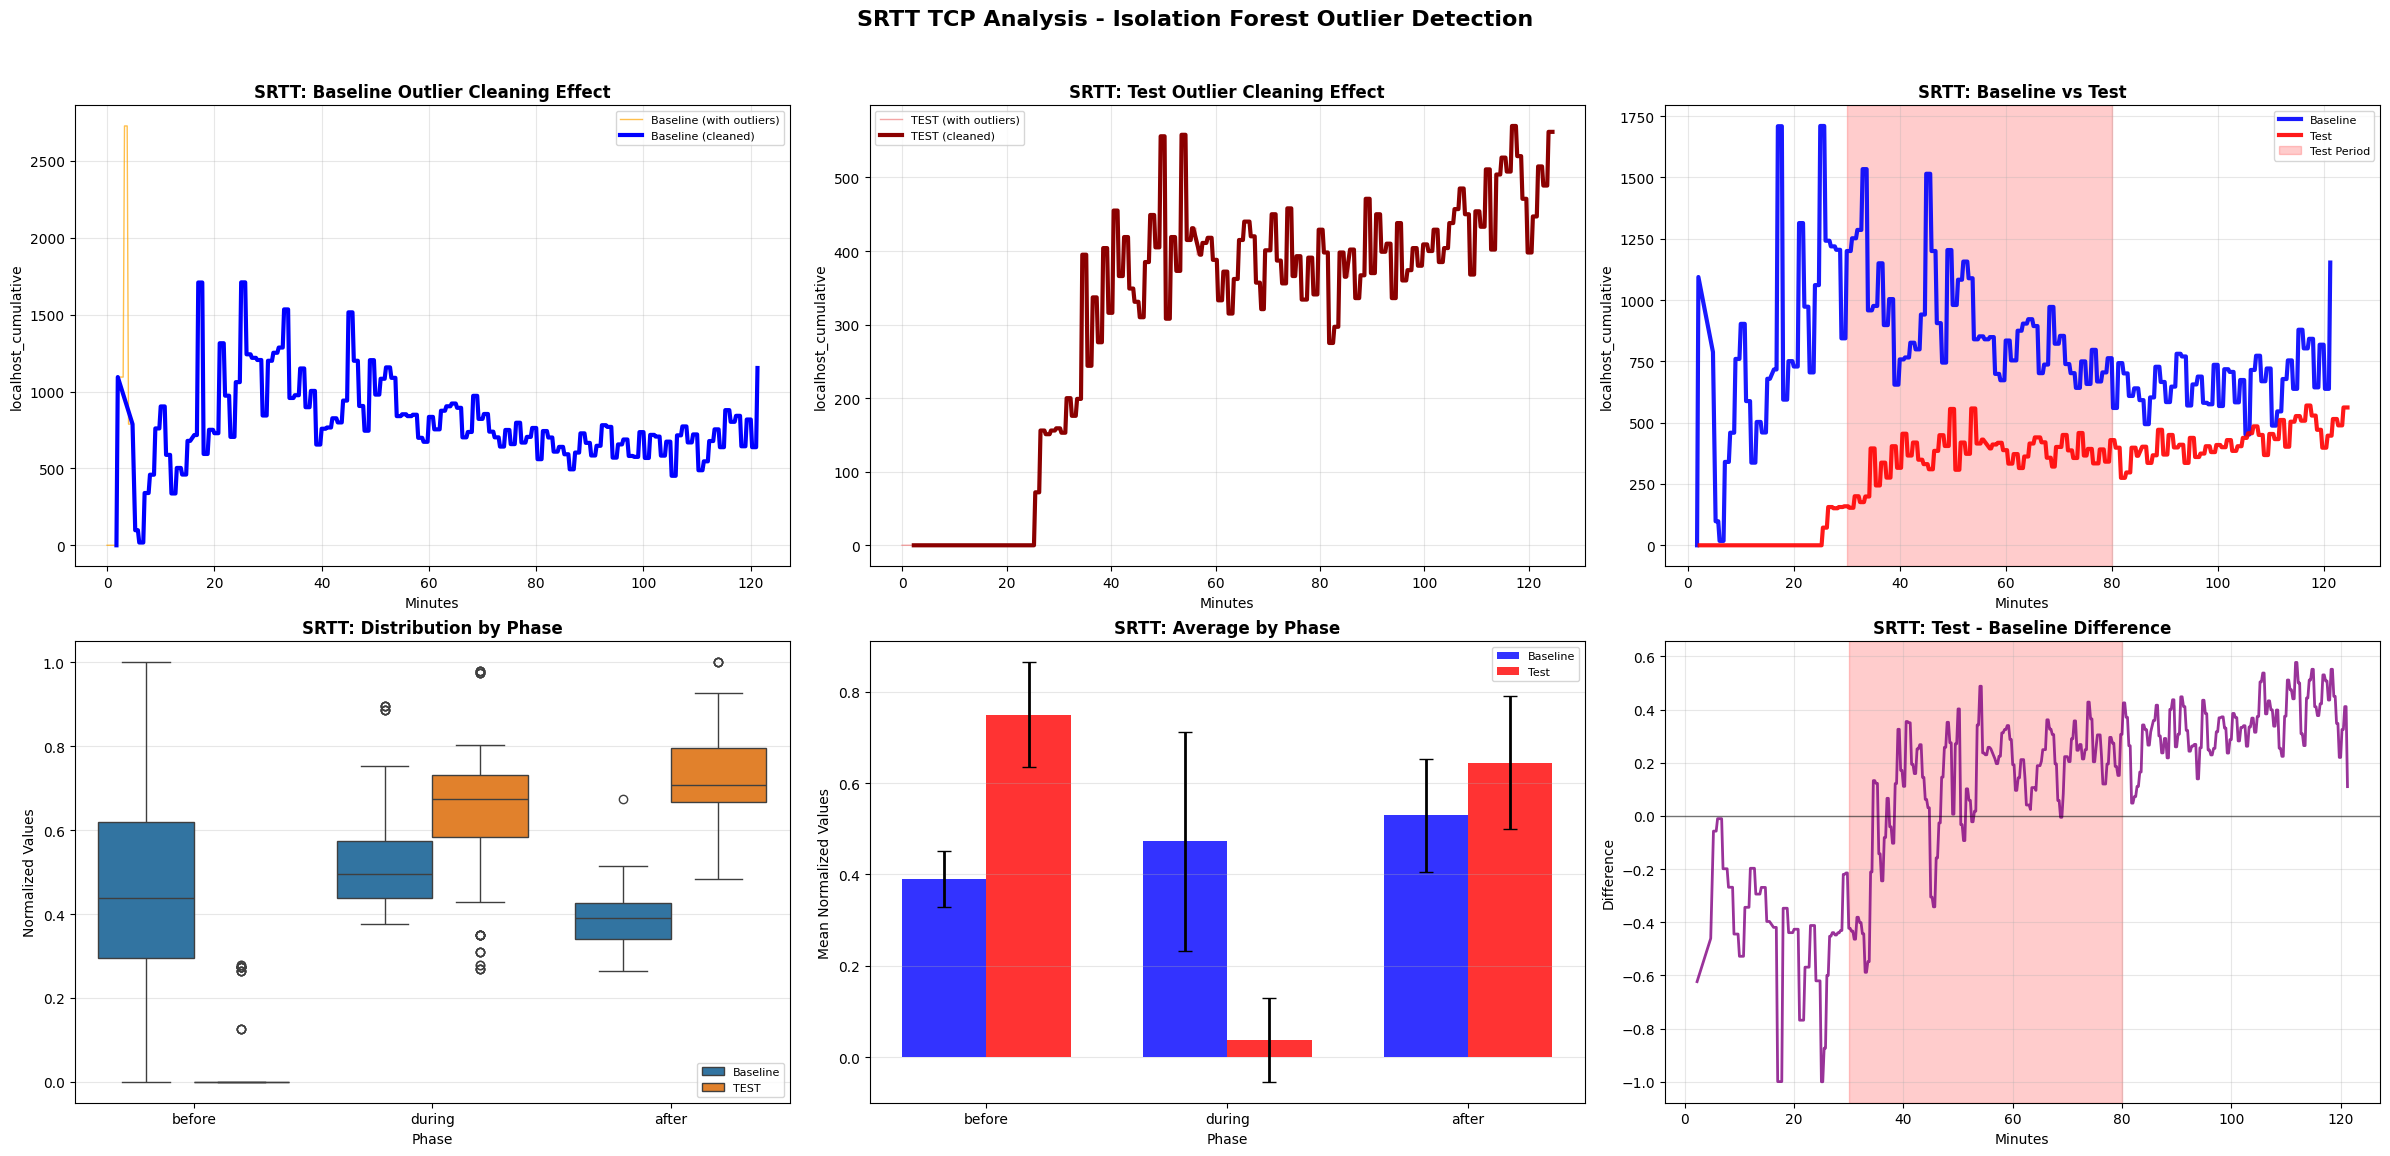


SRTT TCP ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3902  0.0608  0.2643  0.6743
before  0.4725  0.2395  0.0000  1.0000
during  0.5297  0.1237  0.3754  0.8971

📊 TEST STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7490  0.1146  0.4825  1.0000
before  0.0388  0.0920  0.0000  0.2789
during  0.6448  0.1453  0.2684  0.9789

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 17.83, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -8.55, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-35.78, p=  0.0000 (✅ SIGNIFICANT)

📈 TEST IMPACT ON TCP (% CHANGE):
  BEFORE  :  -91.78% (↘️ DECREASE)
  DURING  :  +21.72% (↗️ INCREASE)
  AFTER   :  +91.98% (↗️ INCREASE)

SRTT TCP ANALYSIS SUMMARY
       Phase   Impact (%)      P-Value  Significant  T-Statistic
      before       -91.8%       0.0000          YES        17.83
      during       +21.7%       0.0000     

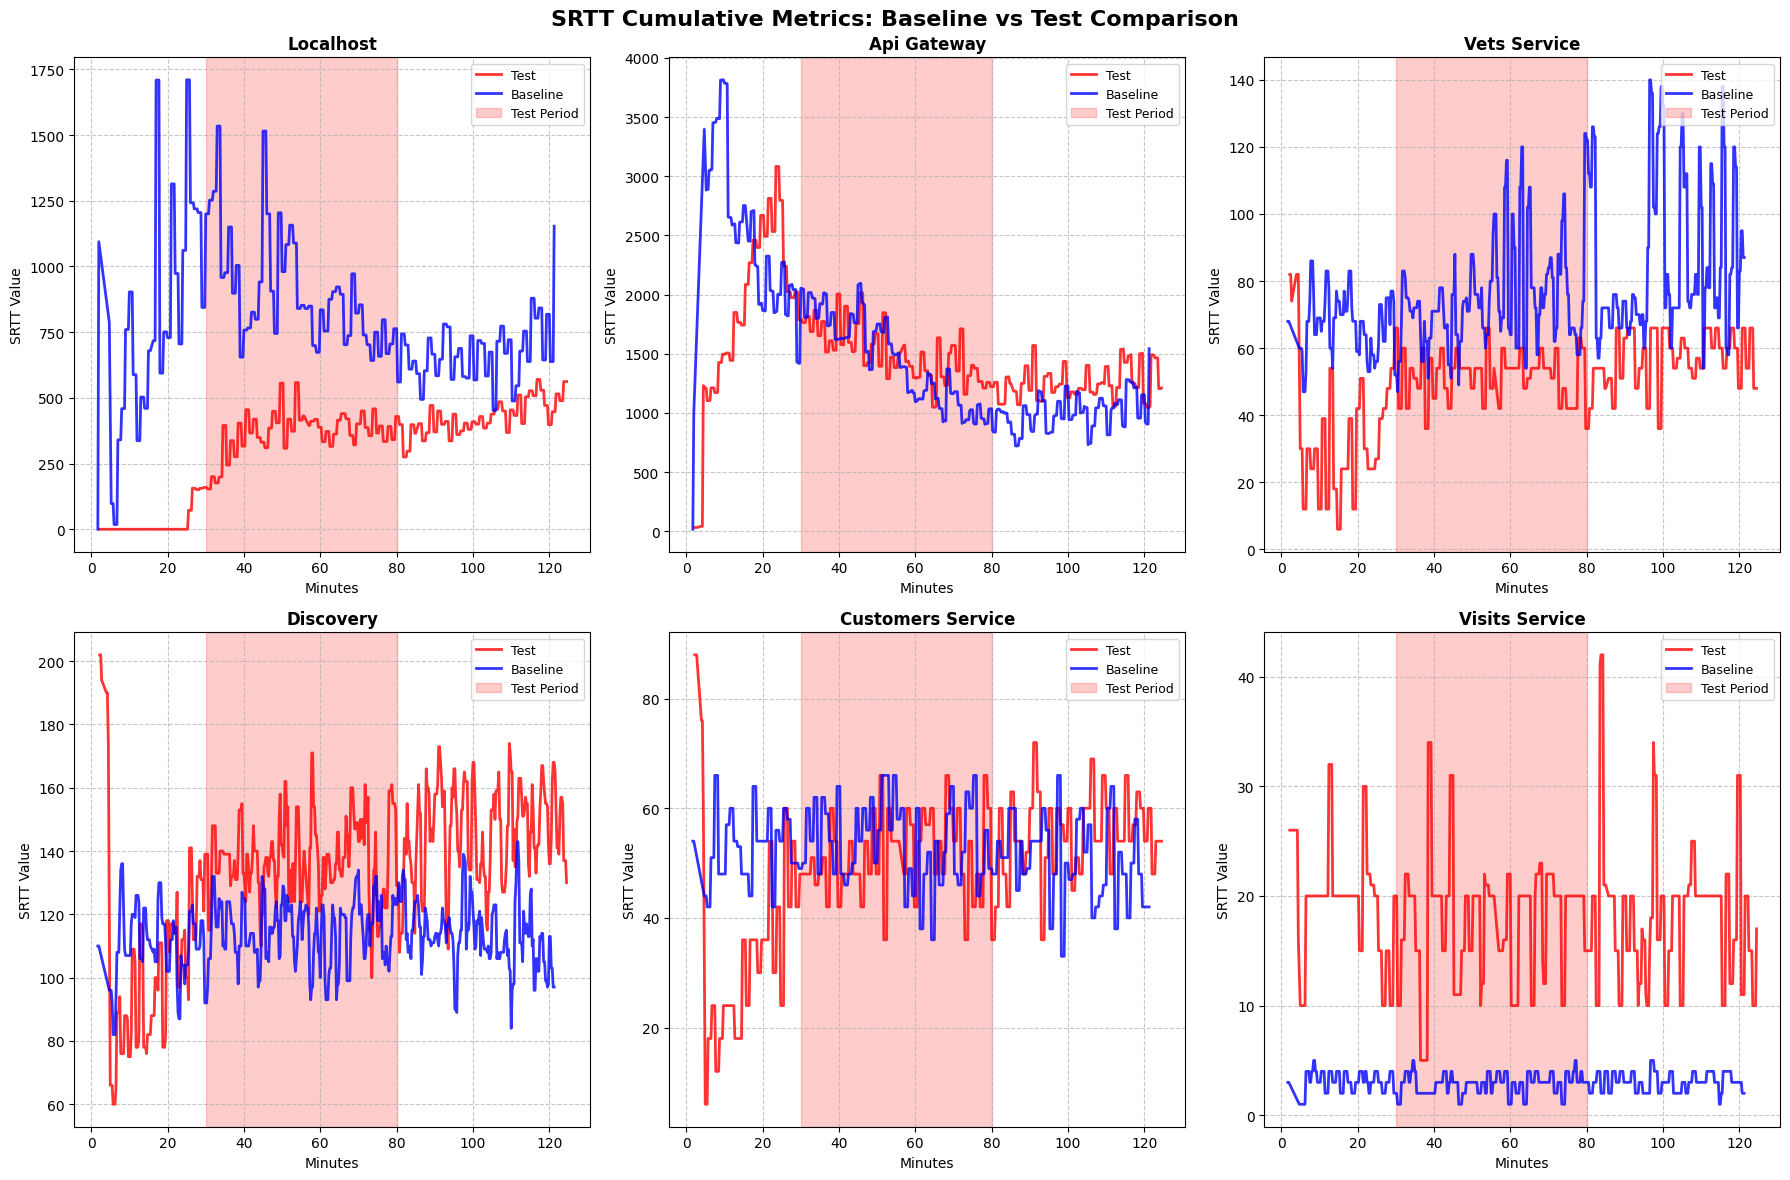

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df_test = pd.read_csv("srtt.csv")
df_baseline = pd.read_csv("../../baseline/tcp related/srtt.csv")

df_test["source"] = "TEST"
df_baseline["source"] = "BASELINE"

df_test["Time"] = pd.to_datetime(df_test["Time"])
df_baseline["Time"] = pd.to_datetime(df_baseline["Time"])

df_test["Minutes"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds() / 60
df_baseline["Minutes"] = (df_baseline["Time"] - df_baseline["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

# Create cumulative SRTT metrics
def create_cumulative_metrics(df):
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}
    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        else:
            service_name = col
        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()
    for service, columns in service_groups.items():
        cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
    return cumulative_df

df_test_cumulative = create_cumulative_metrics(df_test)
df_baseline_cumulative = create_cumulative_metrics(df_baseline)

# Store original datasets for comparison
original_test = df_test_cumulative.copy()
original_baseline = df_baseline_cumulative.copy()

# ISOLATION FOREST OUTLIER DETECTION FOR TCP METRICS
def remove_outliers_isolation_forest_tcp(df, contamination=0.04):
    df_clean = df.copy()
    outlier_stats = {}
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return df_clean, outlier_stats
    
    # Create feature matrix
    if len(numeric_cols) == 1:
        main_col = numeric_cols[0]
        series = df[main_col].fillna(method='ffill').fillna(method='bfill')
        
        features = []
        features.append(series.values)
        
        if len(series) > 10:
            features.append(series.rolling(3, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(7, center=True).std().fillna(0).values)
            features.append(series.diff().fillna(0).values)
            features.append(series.rolling(5).min().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(5).max().fillna(method='ffill').fillna(method='bfill').values)
        
        feature_matrix = np.column_stack(features)
    else:
        feature_matrix = df[numeric_cols].fillna(method='ffill').fillna(method='bfill').values
    
    # Scale features
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    # Apply Isolation Forest
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    )
    
    iso_forest.fit(feature_matrix_scaled)
    outlier_predictions = iso_forest.predict(feature_matrix_scaled)
    outlier_mask = outlier_predictions == -1
    
    # Apply outlier removal
    for col in numeric_cols:
        outlier_stats[col] = {
            'count': outlier_mask.sum(),
            'percentage': (outlier_mask.sum() / len(df[col])) * 100,
            'method': 'isolation_forest'
        }
        
        df_clean.loc[outlier_mask, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')

    outlier_stats['_summary'] = {
        'total_outliers': outlier_mask.sum(),
        'contamination_rate': contamination,
        'method': 'isolation_forest_tcp',
        'features_used': feature_matrix.shape[1]
    }
    
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING
print("📊 Processing SRTT data with Isolation Forest:")
print("  🔍 TEST:")
df_test_clean, test_stats = remove_outliers_isolation_forest_tcp(df_test_cumulative, contamination=0.04)
total_outliers_test = test_stats['_summary']['total_outliers']
features_used_test = test_stats['_summary']['features_used']
print(f"    ✅ Cleaned {total_outliers_test} outliers using {features_used_test} features (4% contamination rate)")

print("  🔍 BASELINE:")
df_baseline_clean, baseline_stats = remove_outliers_isolation_forest_tcp(df_baseline_cumulative, contamination=0.04)
total_outliers_baseline = baseline_stats['_summary']['total_outliers']
features_used_baseline = baseline_stats['_summary']['features_used']
print(f"    ✅ Cleaned {total_outliers_baseline} outliers using {features_used_baseline} features (4% contamination rate)")

# NORMALIZATION FUNCTION
def normalize_df_tcp(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION
def analyze_and_plot_tcp_srtt(test_df, baseline_df, original_test_df, original_baseline_df, delay_minutes, duration_minutes):
    numeric_cols = [col for col in test_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    test_norm = normalize_df_tcp(test_df, numeric_cols)
    baseline_norm = normalize_df_tcp(baseline_df, numeric_cols)
    
    # Get first cumulative column as main metric
    cumulative_cols = [col for col in numeric_cols if col.endswith('_cumulative')]
    if cumulative_cols:
        main_metric = cumulative_cols[0]
    else:
        main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        print("No numeric columns found")
        return None
    
    test_norm = add_phase_column(test_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_test = test_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'TEST': test_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': test_norm[main_metric] - baseline_norm[main_metric]
    })
    
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['TEST'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        test_mean = stats_test.loc[phase, 'mean']
        impact[phase] = ((test_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING with fixed spacing
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(original_baseline_df['Minutes'], original_baseline_df[main_metric], 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df[main_metric], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title('SRTT: Baseline Outlier Cleaning Effect', fontsize=12, fontweight='bold')
    plt.xlabel('Minutes', fontsize=10)
    plt.ylabel(f'{main_metric}', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 2. TEST outlier cleaning effect
    plt.subplot(2, 3, 2)
    plt.plot(original_test_df['Minutes'], original_test_df[main_metric], 
             label='TEST (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(test_df['Minutes'], test_df[main_metric], 
             label='TEST (cleaned)', linewidth=3, color='darkred')
    plt.title('SRTT: Test Outlier Cleaning Effect', fontsize=12, fontweight='bold')
    plt.xlabel('Minutes', fontsize=10)
    plt.ylabel(f'{main_metric}', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison (using original values, not normalized)
    plt.subplot(2, 3, 3)
    plt.plot(baseline_df['Minutes'], baseline_df[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(test_df['Minutes'], test_df[main_metric], 
             label='Test', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Test Period")
    plt.title("SRTT: Baseline vs Test", fontsize=12, fontweight='bold')
    plt.xlabel("Minutes", fontsize=10)
    plt.ylabel(f"{main_metric}", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'TEST', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title('SRTT: Distribution by Phase', fontsize=12, fontweight='bold')
    plt.xlabel('Phase', fontsize=10)
    plt.ylabel('Normalized Values', fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=8)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_test['mean'], width, label='Test', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_test['mean'], yerr=stats_test['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title('SRTT: Average by Phase', fontsize=12, fontweight='bold')
    plt.xlabel('Phase', fontsize=10)
    plt.ylabel('Mean Normalized Values', fontsize=10)
    plt.xticks(x, phases)
    plt.legend(fontsize=8)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title('SRTT: Test - Baseline Difference', fontsize=12, fontweight='bold')
    plt.xlabel('Minutes', fontsize=10)
    plt.ylabel('Difference', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Fixed: More space for main title and better spacing
    plt.suptitle('SRTT TCP Analysis - Isolation Forest Outlier Detection', 
                fontsize=16, fontweight='bold', y=0.96)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    print(f"\n{'='*80}")
    print("SRTT TCP ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 TEST STATISTICS BY PHASE:")
    print(stats_test.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 TEST IMPACT ON TCP (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_test': stats_test,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric
    }

# RUN ANALYSIS 
print(f"\n🔄 Analyzing SRTT data...")
analysis_results = analyze_and_plot_tcp_srtt(
    df_test_clean, 
    df_baseline_clean, 
    original_test,
    original_baseline,
    delay, 
    duration
)

# FINAL SUMMARY
if analysis_results:
    summary_table = []
    for phase in ['before', 'during', 'after']:
        summary_table.append({
            'Phase': phase,
            'Impact (%)': f"{analysis_results['impact'][phase]:+.1f}%",
            'P-Value': f"{analysis_results['t_tests'][phase]['p']:.4f}",
            'Significant': 'YES' if analysis_results['t_tests'][phase]['p'] < 0.05 else 'NO',
            'T-Statistic': f"{analysis_results['t_tests'][phase]['t']:.2f}"
        })

    summary_df = pd.DataFrame(summary_table)
    print(f"\n{'='*60}")
    print("SRTT TCP ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(summary_df.to_string(index=False, col_space=12))

# SRTT individual metrics visualization
cumulative_metrics = [col for col in df_test_cumulative.columns if col.endswith('_cumulative')]
key_cumulative_metrics = cumulative_metrics[:6] if len(cumulative_metrics) >= 6 else cumulative_metrics

if key_cumulative_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SRTT Cumulative Metrics: Baseline vs Test Comparison', fontsize=16, fontweight='bold')
    axes_flat = axes.flatten()

    for i, metric in enumerate(key_cumulative_metrics):
        if i < len(axes_flat):
            ax = axes_flat[i]
            ax.plot(df_test_clean["Minutes"], df_test_clean[metric], 
                   label="Test", color='red', linewidth=2, alpha=0.8)
            ax.plot(df_baseline_clean["Minutes"], df_baseline_clean[metric], 
                   label="Baseline", color='blue', linewidth=2, alpha=0.8)
            ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
            service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
            ax.set_title(f'{service_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel("Minutes", fontsize=10)
            ax.set_ylabel("SRTT Value", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(loc='upper right', fontsize=9)

    for i in range(len(key_cumulative_metrics), len(axes_flat)):
        fig.delaxes(axes_flat[i])

    plt.tight_layout()
    plt.show()